In [24]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import stack_epochs, get_raw_subject_data
import pandas as pd
import seaborn as sns

In [25]:
def reshape_epochs(epochs, n_epochs_to_include):
    """
    Truncate the Epochs to a defined number and merge their time samples.
    
    Parameters:
        epochs (MNE Epochs): The epochs object containing the data.
        n_epochs_to_include (int): The maximum number of epochs to consider.
        
    Returns:
        ndarray: A 2D array where each row represents a time point (merged from epochs)
                 and each column corresponds to a channel.
    """
    # Retrieve and limit the epoch data
    
    data = epochs.get_data()[:n_epochs_to_include, :, :]
    num_epochs, num_channels, num_times = data.shape
    # First, transpose to bring channels to the first axis so that we can merge epoch and time dimensions together
    data_transposed = data.transpose(1, 0, 2)  # Shape: (num_channels, num_epochs, num_times)
    # Combine epoch and time dimensions, then transpose to get (n_epochs*n_times, num_channels)
    reshaped = data_transposed.reshape(num_channels, num_epochs * num_times).T
    return reshaped

In [26]:
# subject = simple_pipeline(subject="01")
epochs = get_raw_subject_data(subject=0)

# Divide each activity and find the minimum number of samples
control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# Reshape all activities
control_reshaped = reshape_epochs(control, min_bound)
left_reshaped = reshape_epochs(left, min_bound)
right_reshaped = reshape_epochs(right, min_bound)
X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

l = control_reshaped.shape[0]
y = np.concatenate([np.full(l, 1), np.full(l, 2), np.full(l, 3)])

# Standardize data (should not be necessary for ICA, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


In [ ]:
ics = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ics.fit_transform(X_scaled)

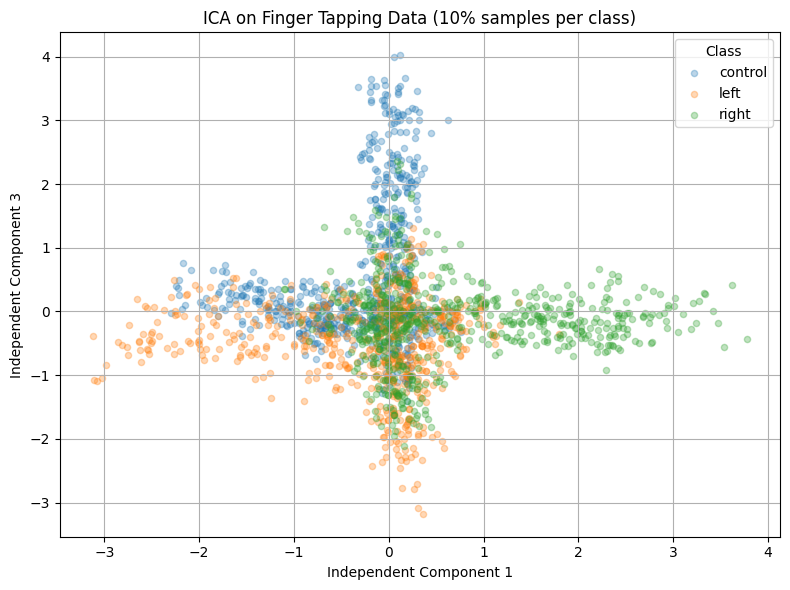

In [53]:
# Mapping labels to names and colors
labels_map = {1: "control", 2: "left", 3: "right"}
colors = {1: "C0", 2: "C1", 3: "C2"}

# Select components to plot
ic_x, ic_y = 0, 2

plt.figure(figsize=(8, 6))
for label in [1, 2, 3]:
    mask = (y == label)
    indices = np.where(mask)[0]
    # Select 10% of the indices (at least one)
    num_points = max(1, int(len(indices) * 0.15))
    selected = np.random.choice(indices, size=num_points, replace=False)
    plt.scatter(X_ica[selected, ic_x],
                X_ica[selected, ic_y],
                color=colors[label],
                alpha=0.3,
                label=labels_map[label],
                s=20)  # Adjusted size for better visibility

plt.xlabel(f'Independent Component {ic_x + 1}')
plt.ylabel(f'Independent Component {ic_y + 1}')
plt.title('ICA on Finger Tapping Data (10% samples per class)')
plt.legend(title="Class")
plt.grid()
plt.tight_layout()
plt.show()

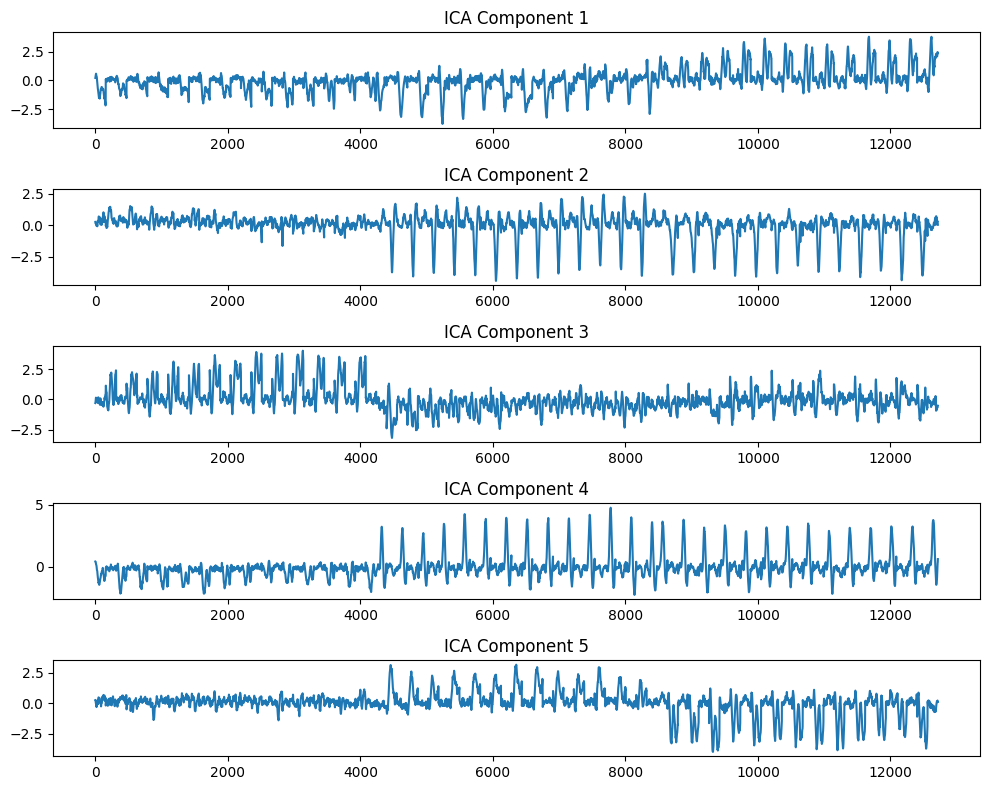

In [51]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()